# Assignment 3: Classification and Feature Engineering

## Objective 2

**Name**: Saurabh Kumar <br>
**Roll No**: 22B3905

In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = './hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

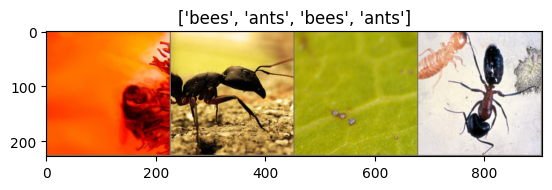

In [4]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model

In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [8]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/saurabh/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44.7M/44.7M [00:06<00:00, 7.73MB/s]


In [9]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6107 Acc: 0.6803
val Loss: 0.2556 Acc: 0.9150

Epoch 1/24
----------
train Loss: 0.4941 Acc: 0.7787
val Loss: 0.2464 Acc: 0.9020

Epoch 2/24
----------
train Loss: 0.3162 Acc: 0.8607
val Loss: 0.1842 Acc: 0.9477

Epoch 3/24
----------
train Loss: 0.4732 Acc: 0.8074
val Loss: 0.2684 Acc: 0.9020

Epoch 4/24
----------
train Loss: 0.6260 Acc: 0.7377
val Loss: 0.3524 Acc: 0.8824

Epoch 5/24
----------
train Loss: 0.3791 Acc: 0.7951
val Loss: 0.2210 Acc: 0.9346

Epoch 6/24
----------
train Loss: 0.4056 Acc: 0.8279
val Loss: 0.2480 Acc: 0.9150

Epoch 7/24
----------
train Loss: 0.4591 Acc: 0.8115
val Loss: 0.1904 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.4143 Acc: 0.8402
val Loss: 0.2170 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.3362 Acc: 0.8648
val Loss: 0.2059 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.3758 Acc: 0.8279
val Loss: 0.2300 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.3076 Acc: 0.8770
val Loss: 0.2268 Acc: 0.9346

Ep

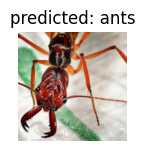

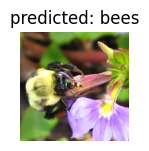

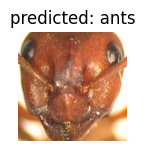

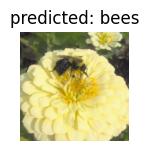

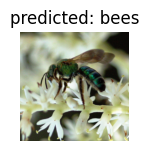

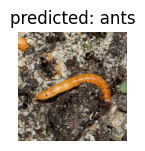

In [10]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [11]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

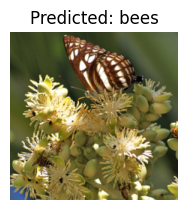

In [12]:
visualize_model_predictions(
    model_conv,
    img_path='./hymenoptera_data/val/bees/72100438_73de9f17af.jpg'
)

plt.ioff()
plt.show()

In [20]:
from torch.utils.data import DataLoader

# Load the pre-trained ResNet18 model and modify it for feature extraction
resnet18 = models.resnet18(pretrained=True)
resnet18 = torch.nn.Sequential(*list(resnet18.children())[:-1])  # Remove the final classification layer
resnet18.eval()  # Set to evaluation mode to avoid any training behavior

# Define image transformation pipeline (matching the training setup of ResNet)
transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize as per ResNet
])

# DataLoader for the training images
train_loader = DataLoader(image_datasets['train'], batch_size=32, shuffle=False)

# Function to extract features from ResNet18
def extract_resnet18_features(data_loader):
    features_list = []
    with torch.no_grad():  # Disable gradient calculation for faster inference
        for inputs, _ in data_loader:
            inputs = inputs.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
            resnet18.to(inputs.device)
            outputs = resnet18(inputs)
            features_list.append(outputs.view(outputs.size(0), -1))  # Flatten the outputs


    features = torch.cat(features_list, dim=0)
    return features.cpu().numpy()


train_features = extract_resnet18_features(train_loader)

test_loader = DataLoader(image_datasets['val'], batch_size=32, shuffle=False)

test_features = extract_resnet18_features(test_loader)
print("Shape of extracted test features:", test_features.shape)  # Should be Mx512
print("Shape of extracted features:", train_features.shape)  # Should be Nx512

Shape of extracted test features: (153, 512)
Shape of extracted features: (244, 512)


In [24]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler

# Standardize the training and test feature sets
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
test_features = scaler.transform(test_features)


# Extract labels from the train and test datasets
train_labels = [label for _, label in image_datasets['train']]
test_labels = [label for _, label in image_datasets['val']]



# Define parameter grids for grid search
logreg_param_grid = {'C': [0.01, 0.1, 1, 10, 100]}  # Regularization strength for Logistic Regression
rf_param_grid = {'max_depth': [5, 10, 15, 20, None], 'n_estimators': [50, 100, 200]}  # Hyperparameters for Random Forest

# Set up and perform Grid Search for Logistic Regression with L2 regularization
logreg = LogisticRegression(penalty='l2', solver='liblinear')
logreg_grid_search = GridSearchCV(logreg, logreg_param_grid, cv=5, scoring='f1')
logreg_grid_search.fit(train_features, train_labels)
best_logreg = logreg_grid_search.best_estimator_

# Set up and perform Grid Search for Random Forest
rf = RandomForestClassifier()
rf_grid_search = GridSearchCV(rf, rf_param_grid, cv=5, scoring='f1')
rf_grid_search.fit(train_features, train_labels)
best_rf = rf_grid_search.best_estimator_

# Predict on test data using the best models from grid search
logreg_predictions = best_logreg.predict(test_features)
rf_predictions = best_rf.predict(test_features)

# Calculate accuracy and F1 score for both models
logreg_accuracy = accuracy_score(test_labels, logreg_predictions)
logreg_f1 = f1_score(test_labels, logreg_predictions, average='weighted')

rf_accuracy = accuracy_score(test_labels, rf_predictions)
rf_f1 = f1_score(test_labels, rf_predictions, average='weighted')

# Print the results
print("Logistic Regression (L2) - Accuracy:", logreg_accuracy)
print("Logistic Regression (L2) - F1 Score:", logreg_f1)
print("Best Logistic Regression Parameters:", logreg_grid_search.best_params_)

print("Random Forest - Accuracy:", rf_accuracy)
print("Random Forest - F1 Score:", rf_f1)
print("Best Random Forest Parameters:", rf_grid_search.best_params_)

Logistic Regression (L2) - Accuracy: 0.954248366013072
Logistic Regression (L2) - F1 Score: 0.954271964534793
Best Logistic Regression Parameters: {'C': 0.01}
Random Forest - Accuracy: 0.9477124183006536
Random Forest - F1 Score: 0.9477124183006536
Best Random Forest Parameters: {'max_depth': None, 'n_estimators': 200}


## Model Comparison: Logistic Regression vs. Random Forest

### Summary of Findings

In this experiment, we compared the performance of two machine learning models, **L2 Regularized Logistic Regression** and **Random Forest Classifier**, for image classification using features extracted from a pre-trained ResNet18 model. The goal was to identify the best-performing model in terms of accuracy and F1 score on the test dataset.

1. **Feature Extraction**: We used ResNet18 as a fixed feature extractor, resulting in a \( N \times 512 \) dimensional feature vector for each image. These features were then used as input for both models.

2. **Hyperparameter Tuning**:
   - For **Logistic Regression**, we performed a grid search over the `C` parameter, which controls the strength of regularization. The best-performing model used an optimal `C` value.
   - For **Random Forest**, we conducted a grid search on `max_depth` (to control tree depth) and `n_estimators` (the number of trees). The optimal parameters were:
     - `max_depth`: None
     - `n_estimators`: 200

3. **Evaluation Metrics**:
   - We evaluated both models using **accuracy** and **F1 score** on the test dataset.

   **Results**:
   - **Logistic Regression (L2)**:
     - Accuracy: **0.9542**
     - F1 Score: **0.9543**
     - Best Parameters: `{'C': 0.01}`
     
   - **Random Forest**:
     - Accuracy: **0.9477**
     - F1 Score: **0.9477**
     - Best Parameters: `{'max_depth': None, 'n_estimators': 200}`

### Conclusion

The Logistic Regression model achieved higher accuracy and F1 score compared to the Random Forest model, indicating that it was more effective for this particular feature set. These results demonstrate the importance of tuning hyperparameters and highlight the effectiveness of logistic regression in this context.



### References

1. PyTorch Tutorials. (n.d.). Transfer Learning for Computer Vision Tutorial. https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
2. [Kaggle Tutorial](https://www.kaggle.com/code/hirotaka0122/feature-extraction-by-resnet)
3. ChatGPT Prompt: How to write function to extract features from pretrained ConvNet.
4. How to compare Logistic Regularization and Random Forest for this.
5. Rephrase this, _f1 scores and other data given_, "we can see that the Regularization works better with better G1 score indicating it was more effective.... "
